Okay, this is getting to the pointy end a bit. In this notebook we take our grids that we made in notebook 6 (6_GMT_processing) and use them, along with the plate boundaries of the plate model to get the intersection with subduction zones and from that, the subduction flux of serpentinite and/or carbonate (or any other variable one desires). We have, of course, two different models (using plate model spreading rates or Pacific Ocean spreading rates) as well as three different ways of measuring uncertainty (see notebook 3); full, batch or individual. We prefer to use 'batch' uncertainty, as it plays a midpoint between full and individual, thus accommodating the inherent uncertainty in spreading rates in the plate model. For serpentinite it is recommended not use 'full' as the bimodal distribution will produce a very (very) large error bar.

Futhermore, there is a separate conceptual issue, especially with using the POSR vs PMSR models, and in the  implementation in the paper.

- In original publication POSR used vertical area (i.e. distance between two hypothetical isochrons) for times prior to 160 Ma in order to deail with uncertainty in ocean basin reconstructions. We also did this with the PMSR values to be consistent.
- This causes a problem though, because when we go to sub flux we use the passed in spreading rate instead of the convergence rate to determine the third dimension of our flux (along with thickness and subduction segment length). E.g. vertical area approach: flux = thickness • spreading rate at point creation • length of subduction zone. vs. thickness • local convergence rate • length of subduction zone
- This means crust formed at slow spreading ridges (i.e. high serpentinite) but subdcuted at times of fast convergence (i.e. late Cretaceous) are likely to underestimate the amount of serpentinite (and the converse is true). This is probably not so important for carbon, as inorganic carbon is stored to a similar order of magnitude irrispective of MOR dynamics.
- In the publication we tried to minimise this be weighting these cases by multiplying the flux by the local convergence rate-to-global mean convergence rate ratio (that later of which is ~65 mm/a). This should have the effect of increasing the estimates during times of high convergence rate in the plate model and lowering the estimates during times of low convergence rates.
- There are two problems though that we did not consider at the time, and now I think are important to address:
    1) Serpentinite has a bimodal disrtibution and forms preferentially at slow ridges, therefore it should be divided by a value closer to ~20 mm/a (here we opt for 17 mm/a as the average spreading rate of ridges spreading more slowly than 40 mm/a) to reflect this, rather than 65 mm/a
    2) For times after 160 Ma (when we have a good seafloor spreading record) we still used the vertical area. In these cases we should be using the local convergence rate from the plate model instead of vertical area, as ther e is a seafloor spreading history. This means we have to divide these values by the spreading rate at creation to go back to point thickness, then use local convergence rate.

In the future I think the best approach will be to somehow use the spreading rate at time X (for pre 160 Ma) as a proxy for convergence rate also at time X, of the great circle drawn between the mid ocean ridge segment and the subduction zone. Or perhaps sampling the Pacific spreading distribution for convergence rate as well. But I'm not quite sure if the current framework would support that super well.

Implementing these changes leads to a revision, in particular, in the Cretaceous of serpentinite subduction flux. This is partly because in the plate model the pacific is slowly spreading between 170 and 140 Ma, then very quickly spreading between 140 and 100 Ma.


In [48]:
import numpy as np
import pygplates
import pandas as pd
import time as tme
import math
import subduction_convergence
import raster_query
import pickle
import csv

In [49]:
#set base directories
datadir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/Sample_Data/'
loaddir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/output/'
savedir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/output/results/'

rotation_filename = '%sMatthews_etal_GPC_2016_410-0Ma_GK07.rot' % datadir
topology_dir = datadir
thickness_grid_dir = loaddir + 'rasters'
#some variables
tessellation_threshold_radians = math.radians(0.5)
search_radius_radians = math.radians(20.0)
smoothing_radius_radians = None

#density carbon g/cm3
carbon_density = 2.26
carbon_densitygkm3 = float(carbon_density * 100000**3)
carbon_densitygm3 = float(carbon_density *100**3)

#density serpentinites g/cm3
serpentinites_density = 3.00 #ranges between 2.7-3.3
serpentinites_densitghhygkm3 = float(serpentinites_density * 100000**3)
serpentinites_densitygm3 = float(serpentinites_density *100**3)

In [50]:
def running_mean(x, N, mode):
    
    '''
    uses np.convolve to return a running mean.
    X: 1D array or list of values to compute running mean
    N: window size of running mean
    mode: valid, full or same (see https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
    for an example of the difference). I default to 'valid'.
    '''
    #x = np.pad(x, (0, N // 2), mode='constant', constant_values = np.nan)
    return np.convolve(x, np.ones((N,))/N, mode=mode)

In [51]:
def get_distribution(variable, method):
    
    '''
    Accesses a pickle file made in '3_Uncertainty_Distributions_per_spreading_rate' which stores a
    distribution of expected variable values at different spreading rates. Three approaches depenting on 'method'.

    Variable (String): What variable (e.g. Carbon, serpentinite) distirbution we want access to.
    Method (String): What distribution method we want to access; (1) individual; (2) batch; (3) full
    
    1) Distribution for each spreading rate is recovered and sampled to perturb
    2) Distirbution for each spreading rate classificaiton is recovered and sampled to perturb
    3) Full distribution for all spreading rates are recovered
    '''
    
    with open('%s%s_thickness_%s.pkl' % (loaddir, variable, method), 'rb') as f:
        distribution = pickle.load(f)
        
    return distribution

In [52]:
def calc_subducting_sediment_volume(time, 
                                    samples, 
                                    variable,
                                    distribution,
                                    thickness_threshold, 
                                    uncertainty_method, 
                                    PMSR=True):
    
    '''
    Variable (string): What variable (e.g. Carbon, serpentinite) we are calculating.
    Thickness_threshold (float): Only used for POSR, to undo some large vales that flag whether a point was made
    under POSR or PMSR.
    Uncertainty_method (string): What distribution method we want to access; (1) individual; (2) batch; (3) full
    PMSR: True for PMSR, or False for POSR
    '''
    
    if PMSR:
        key='PMSR'
    
    else:
        key='POSR'
    print (key)

    #to normalise values against convergence rate if POSR
    mean_spreading_rate = 64.96
    mean_spreading_rate_serp = 17.3
    
    #load topologies and thicknesses
    rotation_model = pygplates.RotationModel(rotation_filename)
    topology_features = pygplates.FeaturesFunctionArgument(
            (topology_dir + 'Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz',
            topology_dir +  'Matthews_etal_GPC_2016_Paleozoic_PlateTopologies.gpmlz')).get_features()
    spreading_grid_filename = thickness_grid_dir + '/{}_SR_{}_Ma.grd'.format(key, time)
    thickness_grid_filename = thickness_grid_dir + '/{}_{}_{}_Ma.grd'.format(key, variable, time)

    #get subduction data
    subduction_convergence_data = subduction_convergence.subduction_convergence(
                rotation_model,
                topology_features,
                tessellation_threshold_radians,
                time)
    subduction_points = [pygplates.PointOnSphere(data[1], data[0]) for data in subduction_convergence_data]
    
    #We want the spreading rate of each point when it was created
    spreading_rate_at_points_creation = raster_query.query_raster_at_points(
                                                        spreading_grid_filename,
                                                        subduction_points,
                                                        search_radius_radians,
                                                        smoothing_radius_radians)
    #
    #Sample the thickness raster at the subduction points.      
    variable_thicknesses = raster_query.query_raster_at_points(
            thickness_grid_filename,
            subduction_points,
            search_radius_radians,
            smoothing_radius_radians)

    
    # Iterate over subduction points/thicknesses and calculate statistics (including subducting volume).
    #we want it per in km3 per Ma
    total_subducting_length_kilometres = np.zeros([samples])
    total_subducting_volume_km_3_per_Ma = np.zeros([samples])

    for subduction_point_index, thickness in enumerate(variable_thicknesses):
        if math.isnan(thickness):
            continue
        
        local_spreading_rate_at_creation = np.round(spreading_rate_at_points_creation[subduction_point_index])
        
        #round up incase
        if local_spreading_rate_at_creation == 0:
            local_spreading_rate_at_creation = 1
        
        if uncertainty_method == 'individual':
            if local_spreading_rate_at_creation > 100:
                local_spreading_rate_at_creation = 100
                
            variable_key = int(local_spreading_rate_at_creation)

            variation = distribution[variable_key-1]
            
        if uncertainty_method == 'batch':
            if local_spreading_rate_at_creation <= 20:
                variable_key = 0
            elif 20 < local_spreading_rate_at_creation <= 40:
                variable_key = 1
            elif 40 < local_spreading_rate_at_creation <= 70:
                variable_key = 0
            else:
                variable_key = 3

            variation = distribution[variable_key]
        
        if uncertainty_method == 'full':
                    variation = distribution
            
#        print (local_spreading_rate_at_creation)            
        #organise our perturbation to generate uncertainty
        
        #variation = distribution[20]
        mean_variation = np.mean(variation)


        perturbation = variation / mean_variation
    
        #print (perturbation)
        #testing here
        #it might be in the spherical interpolation that value average to include a basaltic component
        #in a slow/ultraslow spreading rate, in which case a '0' value would not fully represent
        #what is preserved. So in this case we just put 1 for now. But to be rectified, as this could be
        #a way to ensure more variability within the final results (i.e. resum the thickness at each point
        #if there's a non gabbroic volcanic component, then that crustal thickness is greater?)
        perturbation[perturbation == 0] = 1

        subduction_convergence_item = subduction_convergence_data[subduction_point_index]
        
        subducting_lon = subduction_convergence_item[0]
        subducting_lat = subduction_convergence_item[1]
        convergence_velocity_magnitude_cm_per_yr = subduction_convergence_item[2]
        convergence_obliquity_degrees = subduction_convergence_item[3]
        subducting_length_degrees = subduction_convergence_item[6]
        
        #eh unit conversions, we want the final result to be in km3/Ma
        subducting_length_kilometres = (
            math.radians(subducting_length_degrees) * pygplates.Earth.mean_radius_in_kms)

        total_subducting_length_kilometres += subducting_length_kilometres
        convergence_normal_velocity_km_per_Ma = (
            # 1e-5 converts cm/y to km/y...
            1e-5 * math.fabs(convergence_velocity_magnitude_cm_per_yr) *
            # Negative convergence handled by cos(obliquity_angle)...
            math.cos(math.radians(convergence_obliquity_degrees)) * 1e6)
        
        #because we don't mask, some points may be warped with spinterpolate to be haflway between small and big 
        #usually on the order of 10^1. in this case we divide by the difference by 1000
        #0.01 and 5 for carbon
        #if np.abs(thickness) > 0.01 and np.abs(thickness) < 5:
        #    prev_ind = subduction_point_index
        #    thickness = thicknesses[subduction_point_index-1]
        
        #if PMSR:
        #    spreading_convergence_ratio = np.nan
        #    subducting_volume_km_3_per_Ma = (
        #        np.abs(thickness) * perturbation *\
        #        subducting_length_kilometres * convergence_normal_velocity_km_per_Ma)

        
        if np.abs(thickness) > thickness_threshold:
            print('here')
            #we are in POSR territory
            #pass in the appropriate thickness_threshold

#            if np.abs(thickness) > thickness_threshold:
            #undoes our fix to tell crust formed before 160 Ma from ocean crust afterwards
            thickness = thickness * 1e-6

            #spreading convergence ratio
            #limits the [conceptual] effect of POSR where more/less crust is created at a ridge
            #that then what is passed into the equation
            if time > 160:
                spreading_convergence_ratio = convergence_normal_velocity_km_per_Ma/mean_spreading_rate
                
            else:
                spreading_convergence_ratio = convergence_normal_velocity_km_per_Ma/local_spreading_rate_at_creation
                                
            subducting_volume_km_3_per_Ma = (
            np.abs(thickness) * subducting_length_kilometres * spreading_convergence_ratio *perturbation)#
        else:

            subducting_volume_km_3_per_Ma = np.abs(
            thickness * subducting_length_kilometres * convergence_normal_velocity_km_per_Ma * perturbation)#

        total_subducting_volume_km_3_per_Ma += subducting_volume_km_3_per_Ma

    return (total_subducting_volume_km_3_per_Ma)

In [64]:
#just to get what we want for a bigger analysis
samples=10000
max_time = 200
times = np.arange(0, 200+1, 1)
thickness_threshold = 0.10 #100 m for carbon, 5 km for serp
z = np.zeros([max_time+1, samples])

#change for POSR
variable = 'C'
uncertainty_method = 'batch' #full, individual or batch
model_type = 'PMSR' #PMSR or POSR
#load our desired distribution *
distribution = get_distribution(variable, uncertainty_method)
for ind,time in enumerate(times):
    start_time = tme.time()
    print(time)
    v = calc_subducting_sediment_volume(time,samples, variable, distribution, thickness_threshold, 
                                        uncertainty_method, PMSR=True)
    z[time,::] = v
    print("--- %s seconds for timestep ---" % (tme.time() - start_time))
    
#with open('%s%s_SUB_%s_%s' % (savedir, variable, model_type, uncertainty_method) + '.csv', 'wb') as f:
#    writer = csv.writer(f)
#    writer.writerows(z)

0
PMSR
--- 30.4801299572 seconds for timestep ---
1
PMSR
--- 28.3154499531 seconds for timestep ---
2
PMSR
--- 34.4042289257 seconds for timestep ---
3
PMSR
--- 31.1325120926 seconds for timestep ---
4
PMSR
--- 32.1917998791 seconds for timestep ---
5
PMSR
--- 33.2042229176 seconds for timestep ---
6
PMSR
--- 41.3513839245 seconds for timestep ---
7
PMSR
--- 52.6122581959 seconds for timestep ---
8
PMSR
--- 54.5794858932 seconds for timestep ---
9
PMSR
--- 47.8592700958 seconds for timestep ---
10
PMSR
--- 42.7676868439 seconds for timestep ---
11
PMSR
--- 46.0814831257 seconds for timestep ---
12
PMSR
--- 38.9373631477 seconds for timestep ---
13
PMSR
--- 29.1846649647 seconds for timestep ---
14
PMSR
--- 30.9128859043 seconds for timestep ---
15
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the subducting plate of the subducting shared sub-segment "Trench Baja California COB MG 4-30-07" at 15Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07" at 15Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07 for IZA part 2" at 15Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 15Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find th

--- 29.6119589806 seconds for timestep ---
16
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07" at 16Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07 for IZA part 1" at 16Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07 for IZA part 2" at 16Ma
  warnings.warn(message_string, RuntimeWarning)


--- 33.1176440716 seconds for timestep ---
17
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 17Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Indonesian bndy w AUS-mg" at 17Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07" at 17Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "" at 17Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting share

--- 30.0357789993 seconds for timestep ---
18
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07" at 18Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 18Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the subducting plate of the subducting shared sub-segment "Trench Baja California COB MG 4-30-07" at 18Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "" at 18Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared s

--- 32.2461340427 seconds for timestep ---
19
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07 for IZA part 2" at 19Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07 for IZA part 1" at 19Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the subducting plate of the subducting shared sub-segment "Trench Baja California COB MG 4-30-07" at 19Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "" at 19Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of th

--- 30.6088171005 seconds for timestep ---
20
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07 for IZA part 1" at 20Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07 for IZA part 2" at 20Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "" at 20Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 20Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overrid

--- 32.9151718616 seconds for timestep ---
21
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 21Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Proto Mussau Trench" at 21Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Liguro subduction clean" at 21Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Pacific Melanesia Subduction Zone" at 21Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates

--- 32.5520129204 seconds for timestep ---
22
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "Ligurian subduction clean"
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07 for IZA part 1" at 22Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the subducting plate of the subducting shared sub-segment "Trench Baja California COB MG 4-30-07" at 22Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07" at 22Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of 

--- 33.4764881134 seconds for timestep ---
23
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the subducting plate of the subducting shared sub-segment "Trench Baja California COB MG 4-30-07" at 23Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 23Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07 for IZA part 1" at 23Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07" at 23Ma
  warnings.warn(message_string, RuntimeWarning)


--- 28.9723770618 seconds for timestep ---
24
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 24Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07 for IZA part 1" at 24Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the subducting plate of the subducting shared sub-segment "Trench Baja California COB MG 4-30-07" at 24Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07" at 24Ma
  warnings.warn(message_string, RuntimeWarning)


--- 29.0744400024 seconds for timestep ---
25
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Proto Caroline arc" at 25Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 25Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 25Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07" at 25Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overrid

--- 31.194051981 seconds for timestep ---
26
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 26Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 26Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07" at 26Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "" at 26Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the subducting plate of the subducting shared sub-segment "Trench Baja C

--- 38.4842760563 seconds for timestep ---
27
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 27Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 27Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "" at 27Ma
  warnings.warn(message_string, RuntimeWarning)


--- 38.9555029869 seconds for timestep ---
28
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Western NAM subduction" at 28Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "" at 28Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 28Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 28Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "South America tren

--- 32.9575631618 seconds for timestep ---
29
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 29Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Western NAM subduction" at 29Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 29Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "" at 29Ma
  warnings.warn(message_string, RuntimeWarning)


--- 30.3808948994 seconds for timestep ---
30
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 30Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 30Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "" at 30Ma
  warnings.warn(message_string, RuntimeWarning)


--- 37.1713309288 seconds for timestep ---
31
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 31Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 31Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "" at 31Ma
  warnings.warn(message_string, RuntimeWarning)


--- 39.9314210415 seconds for timestep ---
32
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "" at 32Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 32Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Ligurian subduction clean" at 32Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Alpine subuction clean" at 32Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Sub

--- 43.4405360222 seconds for timestep ---
33
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "" at 33Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 33Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07" at 33Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07 for IZA part 1" at 33Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of

--- 39.3861670494 seconds for timestep ---
34
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "" at 34Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Tethyan Subduction after Afghan block Accretion AG 2012" at 34Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 34Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 34Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting share

--- 38.4213309288 seconds for timestep ---
35
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 35Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "NewCal Obd Oph" at 35Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Mediterranean Subduction, DB 04-2007" at 35Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Tethyan Subduction after Afghan block Accretion AG 2012" at 35Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and 

--- 35.8171141148 seconds for timestep ---
36
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Tonga Trench DiCaprio" at 36Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kermadec Trench DiCaprio" at 36Ma
  warnings.warn(message_string, RuntimeWarning)


--- 40.8933990002 seconds for timestep ---
37
PMSR
--- 37.5159518719 seconds for timestep ---
38
PMSR
--- 39.7813448906 seconds for timestep ---
39
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Alpine subuction clean" at 39Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Ligurian subuction clean" at 39Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Pyrenean subuction clean" at 39Ma
  warnings.warn(message_string, RuntimeWarning)


--- 44.4288818836 seconds for timestep ---
40
PMSR
--- 43.0121669769 seconds for timestep ---
41
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "" at 41Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07" at 41Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Western NAM subduction" at 41Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "South America trench taken from COB file" at 41Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting sha

--- 28.6645522118 seconds for timestep ---
42
PMSR
--- 39.1096789837 seconds for timestep ---
43
PMSR
--- 46.0268712044 seconds for timestep ---
44
PMSR
--- 42.1716899872 seconds for timestep ---
45
PMSR
--- 42.5668640137 seconds for timestep ---
46
PMSR
--- 39.8711020947 seconds for timestep ---
47
PMSR
--- 32.1593830585 seconds for timestep ---
48
PMSR
--- 31.3771870136 seconds for timestep ---
49
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the subducting plate of the subducting shared sub-segment "Subduction Zone - A Gibbons Phd 2012" at 49Ma
  warnings.warn(message_string, RuntimeWarning)


--- 31.6556780338 seconds for timestep ---
50
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the subducting plate of the subducting shared sub-segment "Subduction Zone - A Gibbons Phd 2012" at 50Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Alpine subduction clean" at 50Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction East Ligurian Ocean clean" at 50Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "East Alpine subduction clean" at 50Ma
  warnings.warn(message_string, RuntimeWarning)


--- 37.1271681786 seconds for timestep ---
51
PMSR
--- 41.0588681698 seconds for timestep ---
52
PMSR
--- 36.172000885 seconds for timestep ---
53
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction Zone - A Gibbons Phd 2012" at 53Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Eastern Mediterranean Subduction clean" at 53Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction East Ligurian Ocean clean" at 53Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Tethyan Subduction after Afghan block Accretion AG 2012" at 53Ma
  warnings.warn(message_string, RuntimeWarning)


--- 36.65371418 seconds for timestep ---
54
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Tethyan Subduction after Afghan block Accretion AG 2012" at 54Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction East Ligurian Ocean clean" at 54Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Eastern Mediterranean Subduction clean" at 54Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction zone to close the Tethyan/Lhasa back-arc basin, southward jump after accretion" at 54Ma
  warnings.warn(message_string, RuntimeWarning)
subduc

--- 38.7533919811 seconds for timestep ---
55
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Tethyan Subduction after Afghan block Accretion AG 2012" at 55Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction zone to close the Tethyan/Lhasa back-arc basin, southward jump after accretion" at 55Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "MelanesiaVityaz DiCaprio" at 55Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "SW-dipping SZ southeast of PNG to open BAB" at 55Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_con

--- 37.368819952 seconds for timestep ---
56
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction zone to close the Tethyan/Lhasa back-arc basin, southward jump after accretion" at 56Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07" at 56Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07 for IZA part 1" at 56Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction Zone - A Gibbons Phd 2012" at 56Ma
  warnings.warn(message_string, RuntimeWarning

--- 36.3868350983 seconds for timestep ---
57
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07 for IZA part 1" at 57Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction zone to close the Tethyan/Lhasa back-arc basin, southward jump after accretion" at 57Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction Zone - A Gibbons Phd 2012" at 57Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Japan sub zone fromEarthByte cob MG 4-20-07" at 57Ma
  warnings.warn(message_string, RuntimeWarning

--- 36.5253889561 seconds for timestep ---
58
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction zone to close the Tethyan/Lhasa back-arc basin, southward jump after accretion" at 58Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction Zone - A Gibbons Phd 2012" at 58Ma
  warnings.warn(message_string, RuntimeWarning)


--- 37.1944038868 seconds for timestep ---
59
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction zone to close the Tethyan/Lhasa back-arc basin, southward jump after accretion" at 59Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction Zone - A Gibbons Phd 2012" at 59Ma
  warnings.warn(message_string, RuntimeWarning)


--- 36.1619968414 seconds for timestep ---
60
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction Zone - A Gibbons Phd 2012" at 60Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction zone to close the Tethyan/Lhasa back-arc basin, southward jump after accretion" at 60Ma
  warnings.warn(message_string, RuntimeWarning)


--- 35.9424099922 seconds for timestep ---
61
PMSR
--- 39.2253439426 seconds for timestep ---
62
PMSR
--- 38.4472811222 seconds for timestep ---
63
PMSR
--- 35.3265771866 seconds for timestep ---
64
PMSR
--- 40.4852399826 seconds for timestep ---
65
PMSR
--- 36.7130451202 seconds for timestep ---
66
PMSR
--- 36.7744510174 seconds for timestep ---
67
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "TBD" at 67Ma
  warnings.warn(message_string, RuntimeWarning)


--- 37.4400238991 seconds for timestep ---
68
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "South America trench taken from COB file" at 68Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Vardar Sea Subduction clean" at 68Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kirsehir Subduction clean" at 68Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "TBD" at 68Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-se

--- 37.2419319153 seconds for timestep ---
69
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "TBD" at 69Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Vardar Sea Subduction clean" at 69Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kirsehir Subduction clean" at 69Ma
  warnings.warn(message_string, RuntimeWarning)


--- 40.6659281254 seconds for timestep ---
70
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kirsehir Subduction clean" at 70Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Vardar Sea Subduction clean" at 70Ma
  warnings.warn(message_string, RuntimeWarning)


--- 36.9557330608 seconds for timestep ---
71
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Vardar Sea Subduction clean" at 71Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kirsehir Subduction clean" at 71Ma
  warnings.warn(message_string, RuntimeWarning)


--- 34.5139200687 seconds for timestep ---
72
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kirsehir Subduction clean" at 72Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Vardar Sea Subduction clean" at 72Ma
  warnings.warn(message_string, RuntimeWarning)


--- 35.8496799469 seconds for timestep ---
73
PMSR
--- 35.5916519165 seconds for timestep ---
74
PMSR
--- 35.9484670162 seconds for timestep ---
75
PMSR
--- 40.6307659149 seconds for timestep ---
76
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "Kirshehir Subduction clean"
  warnings.warn(message_string, RuntimeWarning)


--- 37.5108151436 seconds for timestep ---
77
PMSR
--- 37.8365030289 seconds for timestep ---
78
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Vardar Sea Subduction clean" at 78Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "Kirsehir Subduction clean"
  warnings.warn(message_string, RuntimeWarning)


--- 38.0711159706 seconds for timestep ---
79
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Vardar Sea Subduction clean" at 79Ma
  warnings.warn(message_string, RuntimeWarning)


--- 36.3373978138 seconds for timestep ---
80
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Vardar Sea Subduction clean" at 80Ma
  warnings.warn(message_string, RuntimeWarning)


--- 38.8645570278 seconds for timestep ---
81
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Proto Molucca Plate subduction" at 81Ma
  warnings.warn(message_string, RuntimeWarning)


--- 39.3346188068 seconds for timestep ---
82
PMSR
--- 38.3318607807 seconds for timestep ---
83
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Pyrenean Subduction clean" at 83Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Alpine Subduction clean" at 83Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction East Ligurian Ocean subduction zone clean" at 83Ma
  warnings.warn(message_string, RuntimeWarning)


--- 38.331138134 seconds for timestep ---
84
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "MesoTethys subduction zone clean" at 84Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction Zone - A Gibbons Phd 2012" at 84Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Tethyan Subduction after Afghan block Accretion AG 2012" at 84Ma
  warnings.warn(message_string, RuntimeWarning)


--- 34.3153810501 seconds for timestep ---
85
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction Zone - A Gibbons Phd 2012" at 85Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "MesoTethys subduction zone clean" at 85Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Tethyan Subduction after Afghan block Accretion AG 2012" at 85Ma
  warnings.warn(message_string, RuntimeWarning)


--- 33.5870258808 seconds for timestep ---
86
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "MesoTethys subduction zone clean" at 86Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction Zone - A Gibbons Phd 2012" at 86Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Tethyan Subduction after Afghan block Accretion AG 2012" at 86Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Woyla and Proto Andaman Sea Subduction" at 86Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find th

--- 32.9161829948 seconds for timestep ---
87
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction Zone - A Gibbons Phd 2012" at 87Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "MesoTethys subduction zone clean" at 87Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Tethyan Subduction after Afghan block Accretion AG 2012" at 87Ma
  warnings.warn(message_string, RuntimeWarning)


--- 36.6759169102 seconds for timestep ---
88
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction Zone - A Gibbons Phd 2012" at 88Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "MesoTethys subduction zone clean" at 88Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Tethyan Subduction after Afghan block Accretion AG 2012" at 88Ma
  warnings.warn(message_string, RuntimeWarning)


--- 36.8299767971 seconds for timestep ---
89
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction Zone - A Gibbons Phd 2012" at 89Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "MesoTethys subduction zone clean" at 89Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Tethyan Subduction after Afghan block Accretion AG 2012" at 89Ma
  warnings.warn(message_string, RuntimeWarning)


--- 33.6438939571 seconds for timestep ---
90
PMSR
--- 33.1120061874 seconds for timestep ---
91
PMSR
--- 34.2310290337 seconds for timestep ---
92
PMSR
--- 35.0178642273 seconds for timestep ---
93
PMSR
--- 31.4964809418 seconds for timestep ---
94
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Chatham Rise subduction KM" at 94Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Challenger Plateau NE margin" at 94Ma
  warnings.warn(message_string, RuntimeWarning)


--- 37.4959437847 seconds for timestep ---
95
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Challenger Plateau NE margin" at 95Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Chatham Rise subduction KM" at 95Ma
  warnings.warn(message_string, RuntimeWarning)


--- 34.051402092 seconds for timestep ---
96
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Chatham Rise subduction KM" at 96Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Challenger Plateau NE margin" at 96Ma
  warnings.warn(message_string, RuntimeWarning)


--- 35.9357569218 seconds for timestep ---
97
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding plate of the subducting shared sub-segment "Chatham Rise subduction KM" at 97Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Chatham Rise subduction KM" at 97Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "boundary LHR" at 97Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "West Ant SZ" at 97Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Challenger Plateau NE margin"

--- 34.039347887 seconds for timestep ---
98
PMSR
--- 34.4861929417 seconds for timestep ---
99
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Jarrod" at 99Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "West Ant SZ" at 99Ma
  warnings.warn(message_string, RuntimeWarning)


--- 32.5105848312 seconds for timestep ---
100
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "boundary LHR" at 100Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Chatham Rise subduction KM" at 100Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Northern cont. of Eastern Gondwanaland Active Margin" at 100Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Subduction Zone - A Gibbons Phd 2012" at 100Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting pla

--- 31.0008721352 seconds for timestep ---
101
PMSR
--- 32.5431261063 seconds for timestep ---
102
PMSR
--- 34.3659939766 seconds for timestep ---
103
PMSR
--- 34.0852301121 seconds for timestep ---
104
PMSR
--- 38.9177830219 seconds for timestep ---
105
PMSR
--- 42.8757839203 seconds for timestep ---
106
PMSR
--- 40.5693511963 seconds for timestep ---
107
PMSR
--- 39.9496598244 seconds for timestep ---
108
PMSR
--- 42.0685060024 seconds for timestep ---
109
PMSR
--- 40.1380650997 seconds for timestep ---
110
PMSR
--- 35.3071739674 seconds for timestep ---
111
PMSR
--- 33.0345678329 seconds for timestep ---
112
PMSR
--- 32.8320319653 seconds for timestep ---
113
PMSR
--- 37.0340349674 seconds for timestep ---
114
PMSR
--- 43.455548048 seconds for timestep ---
115
PMSR
--- 40.3739919662 seconds for timestep ---
116
PMSR
--- 37.7403719425 seconds for timestep ---
117
PMSR
--- 38.3325779438 seconds for timestep ---
118
PMSR
--- 39.3286869526 seconds for timestep ---
119
PMSR
--- 39.634863

subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "East Gondwana active margin" at 121Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Challenger Plateau NE margin" at 121Ma
  warnings.warn(message_string, RuntimeWarning)


--- 38.9133749008 seconds for timestep ---
122
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Challenger Plateau NE margin" at 122Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "East Gondwana active margin" at 122Ma
  warnings.warn(message_string, RuntimeWarning)


--- 38.6782848835 seconds for timestep ---
123
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "East Gondwana active margin" at 123Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Challenger Plateau NE margin" at 123Ma
  warnings.warn(message_string, RuntimeWarning)


--- 39.614593029 seconds for timestep ---
124
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "East Gondwana active margin" at 124Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Challenger Plateau NE margin" at 124Ma
  warnings.warn(message_string, RuntimeWarning)


--- 35.5940699577 seconds for timestep ---
125
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Philippines Late Cretaceous back-arc" at 125Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Proto Molucca subduction" at 125Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "East Gondwana active margin" at 125Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Challenger Plateau NE margin" at 125Ma
  warnings.warn(message_string, RuntimeWarning)


--- 38.600153923 seconds for timestep ---
126
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "East Gondwana active margin" at 126Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Challenger Plateau NE margin" at 126Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "TBD: Unknown Boundary" at 126Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "TBD" at 126Ma
  warnings.warn(message_string, RuntimeWarning)


--- 38.5636940002 seconds for timestep ---
127
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "East Gondwana active margin" at 127Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Challenger Plateau NE margin" at 127Ma
  warnings.warn(message_string, RuntimeWarning)


--- 38.4559299946 seconds for timestep ---
128
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Challenger Plateau NE margin" at 128Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "South America trench taken from COB file" at 128Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "East Gondwana active margin" at 128Ma
  warnings.warn(message_string, RuntimeWarning)


--- 38.9528400898 seconds for timestep ---
129
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Challenger Plateau NE margin" at 129Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "East Gondwana active margin" at 129Ma
  warnings.warn(message_string, RuntimeWarning)


--- 36.8752520084 seconds for timestep ---
130
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "East Gondwana active margin" at 130Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Challenger Plateau NE margin" at 130Ma
  warnings.warn(message_string, RuntimeWarning)


--- 36.8981761932 seconds for timestep ---
131
PMSR
--- 40.6554450989 seconds for timestep ---
132
PMSR
--- 36.8095231056 seconds for timestep ---
133
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "TBD" at 133Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "TBD: Unknown Boundary" at 133Ma
  warnings.warn(message_string, RuntimeWarning)


--- 37.9481379986 seconds for timestep ---
134
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "TBD" at 134Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "TBD: Unknown Boundary" at 134Ma
  warnings.warn(message_string, RuntimeWarning)


--- 38.0559010506 seconds for timestep ---
135
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "TBD" at 135Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "TBD: Unknown Boundary" at 135Ma
  warnings.warn(message_string, RuntimeWarning)


--- 36.9056651592 seconds for timestep ---
136
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Nutesyn Arc Subduction Zone Test GS" at 136Ma
  warnings.warn(message_string, RuntimeWarning)


--- 34.7721149921 seconds for timestep ---
137
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Nutesyn Arc Subduction Zone Test GS" at 137Ma
  warnings.warn(message_string, RuntimeWarning)


--- 35.0037579536 seconds for timestep ---
138
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Nutesyn Arc Subduction Zone Test GS" at 138Ma
  warnings.warn(message_string, RuntimeWarning)


--- 35.9851529598 seconds for timestep ---
139
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Nutesyn Arc Subduction Zone Test GS" at 139Ma
  warnings.warn(message_string, RuntimeWarning)


--- 34.2692070007 seconds for timestep ---
140
PMSR
--- 37.1262171268 seconds for timestep ---
141
PMSR
--- 35.7180428505 seconds for timestep ---
142
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Nutesyn Arc Subduction Zone Test GS" at 142Ma
  warnings.warn(message_string, RuntimeWarning)


--- 38.5601539612 seconds for timestep ---
143
PMSR
--- 36.8047749996 seconds for timestep ---
144
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Oloy subduction zone  GS" at 144Ma
  warnings.warn(message_string, RuntimeWarning)


--- 36.4987180233 seconds for timestep ---
145
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Oloy subduction zone  GS" at 145Ma
  warnings.warn(message_string, RuntimeWarning)


--- 36.7444200516 seconds for timestep ---
146
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Oloy subduction zone  GS" at 146Ma
  warnings.warn(message_string, RuntimeWarning)


--- 38.5835471153 seconds for timestep ---
147
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Oloy subduction zone  GS" at 147Ma
  warnings.warn(message_string, RuntimeWarning)


--- 35.7063169479 seconds for timestep ---
148
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Oloy subduction zone  GS" at 148Ma
  warnings.warn(message_string, RuntimeWarning)


--- 35.8829758167 seconds for timestep ---
149
PMSR
--- 36.5690779686 seconds for timestep ---
150
PMSR
--- 35.136152029 seconds for timestep ---
151
PMSR
--- 38.1991360188 seconds for timestep ---
152
PMSR
--- 39.3465940952 seconds for timestep ---
153
PMSR
--- 36.6998667717 seconds for timestep ---
154
PMSR
--- 37.8887271881 seconds for timestep ---
155
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Tethyan subduction after Afgan block accretion" at 155Ma
  warnings.warn(message_string, RuntimeWarning)


--- 36.6895461082 seconds for timestep ---
156
PMSR
--- 34.8488848209 seconds for timestep ---
157
PMSR
--- 36.2812020779 seconds for timestep ---
158
PMSR
--- 36.7172410488 seconds for timestep ---
159
PMSR
--- 34.5646920204 seconds for timestep ---
160
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Sunda Jurassic-Cretaceous subduction" at 160Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "East Borneo subduction" at 160Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Junction SZ" at 160Ma
  warnings.warn(message_string, RuntimeWarning)


--- 33.6545879841 seconds for timestep ---
161
PMSR
--- 32.2537651062 seconds for timestep ---
162
PMSR
--- 34.3818390369 seconds for timestep ---
163
PMSR
--- 31.1605780125 seconds for timestep ---
164
PMSR
--- 28.8664820194 seconds for timestep ---
165
PMSR
--- 32.084800005 seconds for timestep ---
166
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the subducting plate of the subducting shared sub-segment "Southern Eurasia SZ" at 166Ma
  warnings.warn(message_string, RuntimeWarning)


--- 33.0082759857 seconds for timestep ---
167
PMSR
--- 32.6501269341 seconds for timestep ---
168
PMSR
--- 31.0631959438 seconds for timestep ---
169
PMSR
--- 31.921077013 seconds for timestep ---
170
PMSR
--- 32.5620651245 seconds for timestep ---
171
PMSR
--- 32.9033658504 seconds for timestep ---
172
PMSR
--- 33.6206629276 seconds for timestep ---
173
PMSR
--- 30.4548988342 seconds for timestep ---
174
PMSR
--- 30.9343559742 seconds for timestep ---
175
PMSR
--- 33.641933918 seconds for timestep ---
176
PMSR
--- 31.0620980263 seconds for timestep ---
177
PMSR
--- 33.1663749218 seconds for timestep ---
178
PMSR
--- 35.0569138527 seconds for timestep ---
179
PMSR
--- 32.9383070469 seconds for timestep ---
180
PMSR
--- 34.1934139729 seconds for timestep ---
181
PMSR
--- 33.9272100925 seconds for timestep ---
182
PMSR
--- 33.9713630676 seconds for timestep ---
183
PMSR
--- 33.4777171612 seconds for timestep ---
184
PMSR
--- 32.5000910759 seconds for timestep ---
185
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Talkeetna-Bonanza SZ GS" at 185Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Western NAM subduction w/hole for Siletzia and before Wrangellia collision" at 185Ma
  warnings.warn(message_string, RuntimeWarning)


--- 32.1783330441 seconds for timestep ---
186
PMSR
--- 33.8992180824 seconds for timestep ---
187
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Koni-Taigonos Subduction Zone GS" at 187Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Monghol-Okosk Subduction Zone MS" at 187Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "East Asia subduction 250-150 Ma" at 187Ma
  warnings.warn(message_string, RuntimeWarning)


--- 33.1372039318 seconds for timestep ---
188
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Koni-Taigonos Subduction Zone GS" at 188Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Monghol-Okosk Subduction Zone MS" at 188Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "East Asia subduction 250-150 Ma" at 188Ma
  warnings.warn(message_string, RuntimeWarning)


--- 32.9346802235 seconds for timestep ---
189
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Monghol-Okosk Subduction Zone MS" at 189Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "East Asia subduction 250-150 Ma" at 189Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Koni-Taigonos Subduction Zone GS" at 189Ma
  warnings.warn(message_string, RuntimeWarning)


--- 34.7900910378 seconds for timestep ---
190
PMSR


subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "East Asia subduction 250-150 Ma" at 190Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Monghol-Okosk Subduction Zone MS" at 190Ma
  warnings.warn(message_string, RuntimeWarning)
subduction_convergence.py:34: RuntimeWarning: Unable to find the overriding and subducting plates of the subducting shared sub-segment "Koni-Taigonos Subduction Zone GS" at 190Ma
  warnings.warn(message_string, RuntimeWarning)


--- 32.9164271355 seconds for timestep ---
191
PMSR
--- 35.8502600193 seconds for timestep ---
192
PMSR
--- 31.2540400028 seconds for timestep ---
193
PMSR
--- 31.0493159294 seconds for timestep ---
194
PMSR
--- 32.1152188778 seconds for timestep ---
195
PMSR
--- 34.1736171246 seconds for timestep ---
196
PMSR
--- 34.765638113 seconds for timestep ---
197
PMSR
--- 34.1576941013 seconds for timestep ---
198
PMSR
--- 34.3564970493 seconds for timestep ---
199
PMSR
--- 32.1173992157 seconds for timestep ---
200
PMSR
--- 32.3555810452 seconds for timestep ---


In [65]:
#quick and dirty plot to make sure it looks somewhat reasonable
import matplotlib.pyplot as plt

#density serpentinites g/cm3
density = 2.26 #serp, 3.0: ranges between 2.7-3.3
densitygkm3 = float(serpentinites_density * 100000**3)
MT_a = densitygkm3/1000/1000000000/1000000

c = z * MT_a

In [66]:
mean = np.asarray([np.mean(i) for i in c])
std = np.asarray([np.std(i) for i in c])

smooth_mean = running_mean(mean, 5, 'valid')
smooth_std = running_mean(std, 5, 'valid')

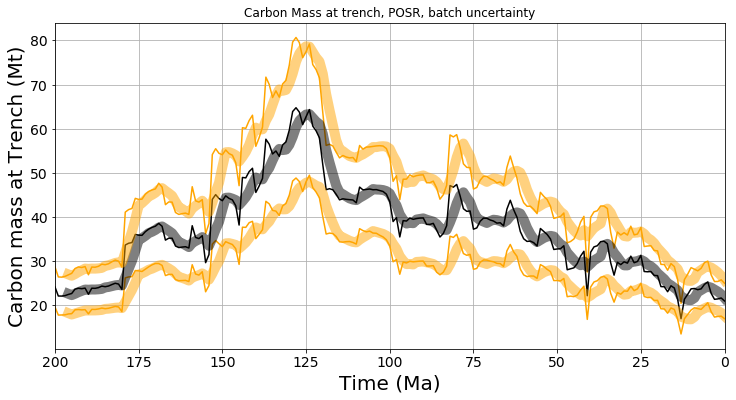

In [71]:
#individual, z2?
plt.figure(figsize=(12,6))

plt.plot(mean, color='k')
plt.plot(mean+std, color='orange')
plt.plot(mean-std, color='orange')

plt.plot(smooth_mean, color='k', lw=10, alpha=0.5)
plt.plot(smooth_mean+smooth_std, color='orange', lw=10, alpha=0.5)
plt.plot(smooth_mean-smooth_std, color='orange', lw=10, alpha=0.5)

plt.xlabel('Time (Ma)', fontsize=20)
plt.ylabel('Carbon mass at Trench (Mt)', fontsize=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('Carbon Mass at trench, POSR, batch uncertainty')

plt.xlim(200,0)
plt.grid()